In [4]:
import json
import geopandas as gpd
import pandas as pd
import contextily as ctx

%load_ext autoreload
%autoreload 2

# geo = json.load(open('./isochrone.json'))
# geo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df = pd.read_csv('../1-data/1-research/cities.latest.csv', index_col=False)
# df.city_id = df.city_id.astype(int)
# df.to_csv('../1-data/1-research/cities.latest.csv', index=False)
df.dtypes

city_id             int64
city_name          object
country_id         object
city_id.1         float64
priority            int64
n_cells           float64
n_req             float64
n_req_ok          float64
frac_req_ok       float64
city_centr_lat    float64
city_centr_lon    float64
region             object
dtype: object

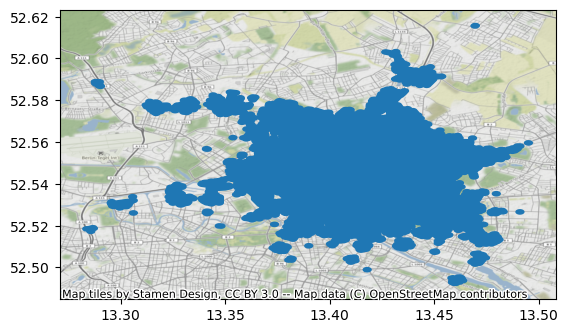

In [17]:
gdf = gpd.GeoDataFrame.from_features(geo['polygons'], crs="EPSG:4326")
gdf = gdf.to_crs(gdf.estimate_utm_crs()).simplify(10).buffer(150).to_crs(gdf.crs)
gdf.to_file('./export.geojson')
ax = gdf.plot()
ctx.add_basemap(ax=ax, crs=gdf.crs)

In [1]:
import gtfs_kit as gk
import logging
logging.getLogger().setLevel(logging.DEBUG)
feed = gk.read_feed('../1-data/2-gtfs/src/f-u-se.gtfs.zip', dist_units='km')
feed

In [31]:
feed.describe()

,indicator,value
0,agencies,"[Samtrafiken, SJ, Visingsöleden, UL, Sörmlands..."
1,timezone,Europe/Stockholm
2,start_date,20230529
3,end_date,20230820
4,num_routes,8990
5,num_trips,450487
6,num_stops,49270
7,num_shapes,0
8,sample_date,20230601
9,num_routes_active_on_sample_date,6581


In [8]:
logging.debug(f'Routes: {feed.routes.shape}')
logging.debug(f'Stops: {feed.stops.shape}')
logging.debug(f'Trips: {feed.trips.shape}')
feed_q = feed.assess_quality()
feed_q

DEBUG:root:Routes: (8990, 6)
DEBUG:root:Stops: (49270, 5)
DEBUG:root:Trips: (450487, 5)


,indicator,value
0,num_route_short_names_duplicated,6878
1,frac_route_short_names_duplicated,0.765072
2,num_stop_time_dists_missing,9824980
3,frac_stop_time_dists_missing,1
4,num_direction_ids_missing,450487
5,frac_direction_ids_missing,1
6,num_trips_missing_shapes,450487
7,frac_trips_missing_shapes,1.0
8,num_departure_times_missing,0
9,frac_departure_times_missing,0.0


In [3]:
from shapely.geometry import Point
import geopandas as gpd
centroid = Point(18.000423079602378, 59.33170104820296)
bbox = centroid.buffer(1)

bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")
bbox_gdf.geometry = bbox_gdf.to_crs(bbox_gdf.estimate_utm_crs()).buffer(5000).to_crs(bbox_gdf.crs)
radius = 10000

newfeed = feed.restrict_to_area(bbox_gdf)
newfeed.routes.head(5)

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
0,1074000000001,74,NaN,SJ InterCity,102,NaN
1,1074000000002,74,NaN,SJ InterCity,102,NaN
2,1074000000003,74,345,NaN,102,NaN
3,1074000000004,74,346,NaN,102,NaN
5,1074000000006,74,NaN,SJ InterCity,102,NaN


In [32]:
newfeed.describe()

,indicator,value
0,agencies,"[SJ, UL, Sörmlandstrafiken, X-trafik, Destinat..."
1,timezone,Europe/Stockholm
2,start_date,20230529
3,end_date,20230820
4,num_routes,2251
5,num_trips,160651
6,num_stops,8903
7,num_shapes,0
8,sample_date,20230601
9,num_routes_active_on_sample_date,1567


In [38]:
feed.trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name
0,1275086100001,000018,22750861101530,Estögaraget,NaN
1,1275086100001,000018,22750861102356,Estögaraget,NaN
2,1275086100001,000018,22750861105331,Estögaraget,NaN
3,1275086100001,000018,22750861107261,Estögaraget,NaN
4,1275086100001,000058,22750861102188,Estögaraget,NaN
...,...,...,...,...,...
450482,1275087500001,000018,22750875409589,Gullmarsplan T-bana,NaN
450483,1275087500001,000018,22750875358638,Gullmarsplan T-bana,NaN
450484,1275087500001,000018,22750875358724,Gullmarsplan T-bana,NaN
450485,1275087500001,000018,22750875358685,Gullmarsplan T-bana,NaN


In [44]:
import importlib
importlib.reload(gk)

<module 'gtfs_kit' from '/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/gtfs_kit/__init__.py'>

In [4]:
newfeed = gk.drop_zombies(newfeed)

In [7]:
newfeed_q = newfeed.assess_quality()
newfeed_q

,indicator,value
0,num_route_short_names_duplicated,1296
1,frac_route_short_names_duplicated,0.575744
2,num_stop_time_dists_missing,3020608
3,frac_stop_time_dists_missing,1
4,num_direction_ids_missing,160651
5,frac_direction_ids_missing,1
6,num_trips_missing_shapes,160651
7,frac_trips_missing_shapes,1.0
8,num_departure_times_missing,0
9,frac_departure_times_missing,0.0


In [9]:
q = newfeed_q.merge(feed_q, on='indicator', suffixes=('_new', '_old'))
q

,indicator,value_new,value_old
0,num_route_short_names_duplicated,1296,6878
1,frac_route_short_names_duplicated,0.575744,0.765072
2,num_stop_time_dists_missing,3020608,9824980
3,frac_stop_time_dists_missing,1,1
4,num_direction_ids_missing,160651,450487
5,frac_direction_ids_missing,1,1
6,num_trips_missing_shapes,160651,450487
7,frac_trips_missing_shapes,1.0,1.0
8,num_departure_times_missing,0,0
9,frac_departure_times_missing,0.0,0.0


In [25]:
newfeed.stops[newfeed.stops.stop_name.str.contains('Lapp')]

,stop_id,stop_name,stop_lat,stop_lon,location_type
2711,740007674,Uppsala Lapplandsresan,59.815785,17.699509,NaN
22877,740038552,Lappetorp,58.741561,17.157189,NaN
42250,740067498,Stora Lappkärrsberget,59.369586,18.062969,NaN
42696,740067987,Lappströmmen,59.675979,18.784376,NaN


In [35]:
newfeed.routes[newfeed.routes.route_id == '1275005000001']

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url
3708,1275005000001,275,50,NaN,700,NaN


In [11]:
newfeed.trips[newfeed.trips.route_id == '1275005000001']

,route_id,service_id,trip_id,trip_headsign,trip_short_name
309469,1275005000001,000058,22750050489129,Lektorsstigen,NaN
309470,1275005000001,000058,22750050489194,Lektorsstigen,NaN
309471,1275005000001,000012,22750050486524,Lektorsstigen,NaN
309472,1275005000001,000012,22750050486547,Lektorsstigen,NaN
309473,1275005000001,000012,22750050487479,Lektorsstigen,NaN
...,...,...,...,...,...
310472,1275005000001,000003,22750050491206,Odenplan T-bana,NaN
310473,1275005000001,000006,22750050488754,Odenplan T-bana,NaN
310474,1275005000001,000003,22750050490780,Odenplan T-bana,NaN
310475,1275005000001,000058,22750050493355,Odenplan T-bana,NaN


In [20]:
newfeed = newfeed.create_shapes(all_trips=True)

In [21]:
newfeed.map_routes(route_ids=['1275005000001'])

In [13]:
newfeed.get_stops(trip_ids=['22750050489129'])

,stop_id,stop_name,stop_lat,stop_lon,location_type
11647,740021013,Odenplan T-bana,59.342956,18.049704,NaN
12076,740021645,Universitetet T-bana,59.365567,18.054891,NaN
28126,740045995,Frejgatan (på Roslagsgatan),59.347997,18.058845,NaN
28127,740045996,Surbrunnsgatan,59.346253,18.060031,NaN
28147,740046026,Stadsbiblioteket,59.344151,18.055408,NaN
28162,740046043,Universitetsvägen,59.362216,18.057589,NaN
28224,740046119,Naturhistoriska riksmuseet,59.368057,18.052663,NaN
28238,740046136,Roslagstull (på Ingemarsgatan),59.349398,18.058376,NaN
42248,740067494,Bergiusvägen,59.370351,18.053501,NaN
42249,740067497,Professorsslingan,59.370128,18.060700,NaN


In [ ]:
newfeed.compute_stop_stats(stop_ids=['740067497'], dates=['20230601'], split_directions=True)

ValueError: At least one trip direction ID value must be non-NaN.

In [27]:
newfeed

In [22]:
newfeed.routes.route_long_name.value_counts()

route_long_name
Arlanda Express       190
41                    185
Vy Bus4You            174
SJ Regionaltåg         92
40                     84
SJ Snabbtåg X2000      75
SJ InterCity           65
MTRX                   57
Vy Express             54
SJ Snabbtåg SJ3000     53
Snälltåget             17
Härjedalingen          15
SJ Nattåg              11
MasExpressen           11
Flixbus                 8
Y-buss                  7
Flygbussarna            6
Vy Nattåg               6
42X                     2
Roslagsbanan 27         1
Västervik Express       1
Linje 43                1
Ressels Rederi          1
Trosabussen             1
Linje 42X               1
Linje 48                1
Linje 40                1
Linje 41                1
Linje 44                1
Lidingöbanan 21         1
89                      1
83                      1
Djurgårdsfärjan 82      1
80E                     1
80X                     1
80                      1
Tvärbanan 31            1
Nockebybanan 12       